In [0]:
batch_size = 100
epochs = 250

In [2]:
from keras.datasets import cifar10
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed=543)

# Load minst data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Concatenate train and test
x_data = np.concatenate((x_train, x_test), axis = 0)
y_data = np.concatenate((y_train, y_test), axis = 0)
# Reshape
x_data = x_data.reshape(x_data.shape[0], 32, 32, 3)
x_data = x_data.astype('float32')
# Standardize
x_data = x_data/255
# Flatten y 
y_data = y_data.flatten()

# Index in cross validation
fold_num = 10
L = len(x_data)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]
    
index = np.arange(L)    

# Function for adding label noise
def add_label_noise(y_origin, label_noise):
    y_noised = y_origin.copy()
    print('Label without noise:', y_origin[:20])
    #
    for i in range(len(y_noised)):
        if np.random.rand() < label_noise:
            while True:
                wrong_label = np.random.randint(low=0, high=9)
                if y_noised[i] != wrong_label:
                    y_noised[i] = wrong_label
                    break
    #
    print('With noise level', label_noise, ':', y_noised[:20])
    return y_noised

Using TensorFlow backend.


In [3]:
from keras.models import Sequential  
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D  
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', input_shape=(32, 32, 3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=36, kernel_size=(5,5), padding='same', activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  
    model.add(Dense(10, activation='softmax'))  
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 36)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [0]:
import keras.backend as K
import tensorflow as tf

# Define linearly scored categorical crossentropy
# Higher CCE with lower score

def linearly_scored_categorical_crossentropy(y_true, y_pred):
    num = tf.shape(y_true)[0]
    num_float = tf.cast(num, dtype = tf.float32)
    rank = tf.range(start = 1, limit = num + 1, delta = 1)
    rank_float = tf.cast(rank, dtype = tf.float32)
    score = tf.cast((rank_float - 1) / (num_float - 1.0), dtype = tf.float32)
    CCE = K.categorical_crossentropy(y_true, y_pred)
    sorted_CCE = tf.nn.top_k(tf.reshape(CCE, shape = (num,)), k = num)[0]
    return tf.reduce_sum(score * sorted_CCE)

# Define the trimmed categorical crossentropy.
# Trimming higher CCE

def trimmed_categorical_crossentropy(trim_percent):
    def trimmed_categorical_crossentropy_calculation(y_true, y_pred):
        num_all = tf.shape(y_true)[0]
        num_all_float = tf.cast(num_all, dtype = tf.float32)
        trim_percent_float = tf.constant(trim_percent, dtype = tf.float32)
        num_zeros = tf.cast(num_all_float * trim_percent_float, dtype = tf.int32)
        num_ones = num_all - num_zeros
        score = tf.concat((tf.zeros(num_zeros), tf.ones(num_ones)), axis = 0)
        CCE = K.categorical_crossentropy(y_true, y_pred)
        sorted_CCE = tf.nn.top_k(tf.reshape(CCE, shape = (num_all,)), k = num_all)[0]
        return tf.reduce_sum(score * sorted_CCE) 
    return trimmed_categorical_crossentropy_calculation

In [5]:
CCE = []
LSCCE = []
TCCE01 = []
TCCE03 = []

for i, label_noise in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5]):
    CCE_temp = []
    LSCCE_temp = []
    TCCE01_temp = []
    TCCE03_temp = []
    # Add noise
    y_noise = add_label_noise(y_data, label_noise)
    # One-hot encoding 
    y_unnoised = np_utils.to_categorical(y_data, 10)
    y_noise = np_utils.to_categorical(y_noise, 10)
    #
    for k in range(fold_num):
        # Select index sets.
        test_seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
        test_index = index[test_seq_index]
        if(k+1 == fold_num):
            val_seq_index = range(index_begin[0], (index_begin[0] + fold_length[0]))
            val_index = index[val_seq_index]
        else:
            val_seq_index = range(index_begin[k+1], (index_begin[k+1] + fold_length[k+1]))
            val_index = index[val_seq_index]
        train_index = np.delete(index, np.concatenate((test_seq_index, val_seq_index), axis = 0))
        # Using label noise in y_train and y_val, but not in y_test
        x_train = x_data[train_index]
        x_val = x_data[val_index]
        x_test = x_data[test_index]
        y_train = y_noise[train_index]
        y_val = y_noise[val_index]
        y_test = y_unnoised[test_index]
        #
        # Testing 'categorical_crossentropy'
        model = create_model()
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                  batch_size=batch_size, epochs=epochs, verbose=0,
                  callbacks =[EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min')])
        score = model.evaluate(x_test, y_test, verbose=0)
        CCE_temp.append(score[1])
        K.clear_session()
        del model
        # Testing 'linearly_scored_categorical_crossentropy'
        model = create_model()
        model.compile(loss=linearly_scored_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
        model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                  batch_size=batch_size, epochs=epochs, verbose=0,
                  callbacks =[EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min')])
        score = model.evaluate(x_test, y_test, verbose=0)
        LSCCE_temp.append(score[1])
        K.clear_session()
        del model
        # Testing 'trimmed_categorical_crossentropy, trim_percent 0.1'
        model = create_model()
        model.compile(loss=trimmed_categorical_crossentropy(0.1), optimizer='adam', metrics=['accuracy'])
        model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                  batch_size=batch_size, epochs=epochs, verbose=0,
                  callbacks =[EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min')])
        score = model.evaluate(x_test, y_test, verbose=0)
        TCCE01_temp.append(score[1])
        K.clear_session()
        del model
        # Testing 'trimmed_categorical_crossentropy, trim_percent 0.3'
        model = create_model()
        model.compile(loss=trimmed_categorical_crossentropy(0.3), optimizer='adam', metrics=['accuracy'])
        model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                  batch_size=batch_size, epochs=epochs, verbose=0,
                  callbacks =[EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min')])
        score = model.evaluate(x_test, y_test, verbose=0)
        TCCE03_temp.append(score[1])
        K.clear_session()
        del model

    #
    CCE.append(CCE_temp)
    LSCCE.append(LSCCE_temp)
    TCCE01.append(TCCE01_temp)
    TCCE03.append(TCCE03_temp)
    print('label_noise =', label_noise, ': CCE:', np.mean(CCE[i]), '; LSCCE:', np.mean(LSCCE[i]), 
                                        '; TCCE(0.1):', np.mean(TCCE01[i]), '; TCCE(0.3):', np.mean(TCCE03[i]))

Label without noise: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
With noise level 0 : [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
label_noise = 0 : CCE: 0.7130666673183441 ; LSCCE: 0.7107000052928925 ; TCCE(0.1): 0.7069666624069214 ; TCCE(0.3): 0.6273666739463806
Label without noise: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
With noise level 0.1 : [6 9 0 4 1 1 2 7 8 3 6 7 7 2 9 9 9 3 2 6]
label_noise = 0.1 : CCE: 0.6719333291053772 ; LSCCE: 0.6946500062942504 ; TCCE(0.1): 0.690399992465973 ; TCCE(0.3): 0.6250500082969666
Label without noise: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
With noise level 0.2 : [6 9 9 4 1 1 2 7 8 4 4 4 7 2 2 9 6 3 2 7]
label_noise = 0.2 : CCE: 0.6361999988555909 ; LSCCE: 0.6638499975204468 ; TCCE(0.1): 0.6521166563034058 ; TCCE(0.3): 0.6182833254337311
Label without noise: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
With noise level 0.3 : [6 3 9 4 1 1 2 7 8 3 0 0 7 6 3 6 9 4 2 1]
label_noise = 0.3 : CCE: 0.5976666688919068 ; LSCCE: 0.6383000016212463 ; TCCE(0.1): 

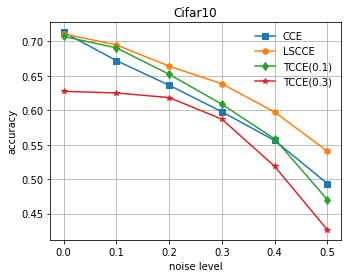

In [6]:
# Summarize history for accuracy.

noise_level = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure('accuracy', figsize = (5.2, 4.0))
plt.plot(noise_level, np.mean(CCE, axis=1), "s-")
plt.plot(noise_level, np.mean(LSCCE, axis=1), "h-")
plt.plot(noise_level, np.mean(TCCE01, axis=1), "d-")
plt.plot(noise_level, np.mean(TCCE03, axis=1), "*-")
plt.title('Cifar10')
plt.ylabel('accuracy')
plt.xlabel('noise level')
plt.legend(['CCE', 'LSCCE', 'TCCE(0.1)', 'TCCE(0.3)'], loc = "best", frameon = False)
plt.grid(True)
plt.savefig('Cifar10.jpg', dpi=500)
plt.show()